## Imports

In [1]:
from pyabc import (ABCSMC, Distribution, RV,
                   History, Model,
                   ModelResult, MedianEpsilon)
from pyabc.populationstrategy import AdaptivePopulationSize
from pyabc.distance_functions import PNormDistance, WeightedPNormDistance
from pyabc.transition import MultivariateNormalTransition
from pyabc.visualization import plot_kde_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
%config Inline.Backend.figure_format = 'retina'
import os
import tempfile
import math
import pandas as pd
import scipy as sp
import numpy as np
import subprocess
from io import BytesIO
from pyabc_custom import simulate, voltage_dependence

## Get experimental measurements

In [2]:
myokit_python = ("/tmp/chouston/miniconda3/envs" +
                 "/ion_channel_ABC/bin/python")
args = [myokit_python, "get_measurements.py"]
args.append('ina_nrvm')
re = subprocess.run(args, stdout=subprocess.PIPE)
measurements = pd.read_table(BytesIO(re.stdout),
                             delim_whitespace=True,
                             header=0, index_col=False)
obs = measurements.to_dict()['y']

## Set limits and generate initial uniform priors

In [12]:
limits = dict(
              p1=(0, 100),
              p2=(-100, 0),
              p3=(0, 1),
              p4=(0, 100),
              p5=(-100, 0), # Expanded from (-10, 0) after test run
              p6=(0, 1),
              p7=(0, 1000), # Expanded from (0, 500) after test run
              q1=(0, 100),
              q2=(0, 50))
#              q3=(0, 10),
#              q4=(-50, 50),
#              q5=(-50, 50),
#              q6=(0, 1),
#              q7=(0, 100),
#              q8=(-50, 50),
#              q9=(0, 10),
#              q10=(0, 1),
#              q11=(0, 10),
#              r1=(0, 100),
#              r2=(-1, 0),
#              r3=(-50, 50),
#              r4=(-10, 0),
#              r5=(0, 10),
#              r6=(0, 100),
#              r7=(0, 1),
#              r8=(0, 100),
#              r9=(-10, 0),
#              r10=(0, 1),
#              r11=(0, 10),
#              r12=(-0.1, 0),
#              r13=(0, 1),
#              r14=(-1, 0),
#              r15=(-1, 0),
#              r16=(0, 100))
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

In [4]:
prior.rvs()

<Parameter 'g_Na': 23.80787711862319, 'p1': 38.84163839361111, 'p2': -3.2242170670604935, 'p3': 0.18518314086240084, 'p4': 29.275254038808473, 'p5': -74.64462757191382, 'p6': 0.39678967644814345, 'p7': 763.2054684887083, 'q1': 32.01390081898522, 'q2': 41.98337555252276>

## Define distance function and model

In [5]:
distance = PNormDistance(p=2)
#distance = WeightedPNormDistance(p=2, adaptive=True)

In [6]:
class MyokitSimulation(Model):
    
    def sample(self, pars):
        try:
            res = simulate('ina_nrvm', **pars).to_dict()['y']
        except:
            res = {key: float("inf") for key in range(len(obs))}
        return res
    
    def accept(self, pars, sum_stats_calculator, distance_calculator, eps) \
            -> ModelResult:
        distance_result = self.distance(pars, sum_stats_calculator,
                                        distance_calculator)
        if math.isnan(distance_result.distance):
            distance_result.accepted = False
            return distance_result
        accepted = distance_result.distance <= eps
        distance_result.accepted = accepted
        return distance_result

## Test the model runs for normal settings

In [7]:
MyokitSimulation().sample({})

{0: -3.13706e-07,
 1: -2.94552e-06,
 2: -2.7034140000000002e-05,
 3: -0.0002382541,
 4: -0.0019324989999999998,
 5: -0.0134104,
 6: -0.07106666,
 7: -0.2541465,
 8: -0.5595446,
 9: -0.8566935,
 10: -0.9999998999999999,
 11: -0.9954583,
 12: -0.9055509,
 13: -0.7835675999999999,
 14: -0.6539904000000001,
 15: -0.5281216,
 16: -0.4084712,
 17: -0.2924632,
 18: -0.177555,
 19: -0.06159789,
 20: 0.05682404,
 21: 0.1785158,
 22: 1.29328e-07,
 23: 1.279872e-06,
 24: 1.241708e-05,
 25: 0.0001160556,
 26: 0.001001977,
 27: 0.007431882,
 28: 0.04229659,
 29: 0.163338,
 30: 0.3908224,
 31: 0.6552316999999999,
 32: 0.8451494,
 33: 0.9400171999999999,
 34: 0.9687783000000001,
 35: 0.9667814,
 36: 0.9529956,
 37: 0.9397129000000001,
 38: 0.9330955,
 39: 0.9328515,
 40: 0.9380976000000001,
 41: 0.9472593,
 42: 0.9595992,
 43: 0.9730485000000001,
 44: 0.9866985,
 45: 1.0,
 46: 0.9999979999999999,
 47: 1.0,
 48: 0.9999126,
 49: 0.9995881,
 50: 0.9991674999999999,
 51: 0.9931494000000001,
 52: 0.962580

## Define ABCSMC parameters and initialize database

In [8]:
db_path = ("sqlite:///" +
           os.path.join(tempfile.gettempdir(), "ina_korhonen.db"))

In [9]:
abc = ABCSMC(models=MyokitSimulation(),
             parameter_priors=prior,
             distance_function=distance,
             population_size=AdaptivePopulationSize(
                 5000, 0.5, 
                 min_population_size=500,
                 max_population_size=10000),
            eps=MedianEpsilon(100, median_multiplier=1.0))
abc_id = abc.new(db_path, obs)

KeyboardInterrupt: 

## Run ABCSMC

In [14]:
history = abc.run(max_nr_populations=20, minimum_epsilon=0.01)

INFO:ABC:t:30 eps:1.1871793376882145
INFO:Adaptation:Change nr particles 5000 -> 1311
INFO:ABC:t:31 eps:1.161135995107641
INFO:Adaptation:Change nr particles 1311 -> 1355
INFO:ABC:t:32 eps:1.1362704396273662
INFO:Adaptation:Change nr particles 1355 -> 1536
INFO:ABC:t:33 eps:1.1111200906131005
INFO:Adaptation:Change nr particles 1536 -> 1733
INFO:ABC:t:34 eps:1.0892706369044023
INFO:Adaptation:Change nr particles 1733 -> 1846
INFO:ABC:t:35 eps:1.0731973645575046
INFO:Adaptation:Change nr particles 1846 -> 1856
INFO:ABC:t:36 eps:1.0585150216371988
INFO:Adaptation:Change nr particles 1856 -> 2077
INFO:ABC:t:37 eps:1.0451172992509477
INFO:Adaptation:Change nr particles 2077 -> 2052
INFO:ABC:t:38 eps:1.0328407004846392
INFO:Adaptation:Change nr particles 2052 -> 1907
INFO:ABC:t:39 eps:1.0234550954280097
INFO:Adaptation:Change nr particles 1907 -> 10000
INFO:ABC:t:40 eps:1.0148328423234565
INFO:ABC:t:41 eps:1.0071511160793283
INFO:Adaptation:Change nr particles 910 -> 697
INFO:ABC:t:42 eps:1

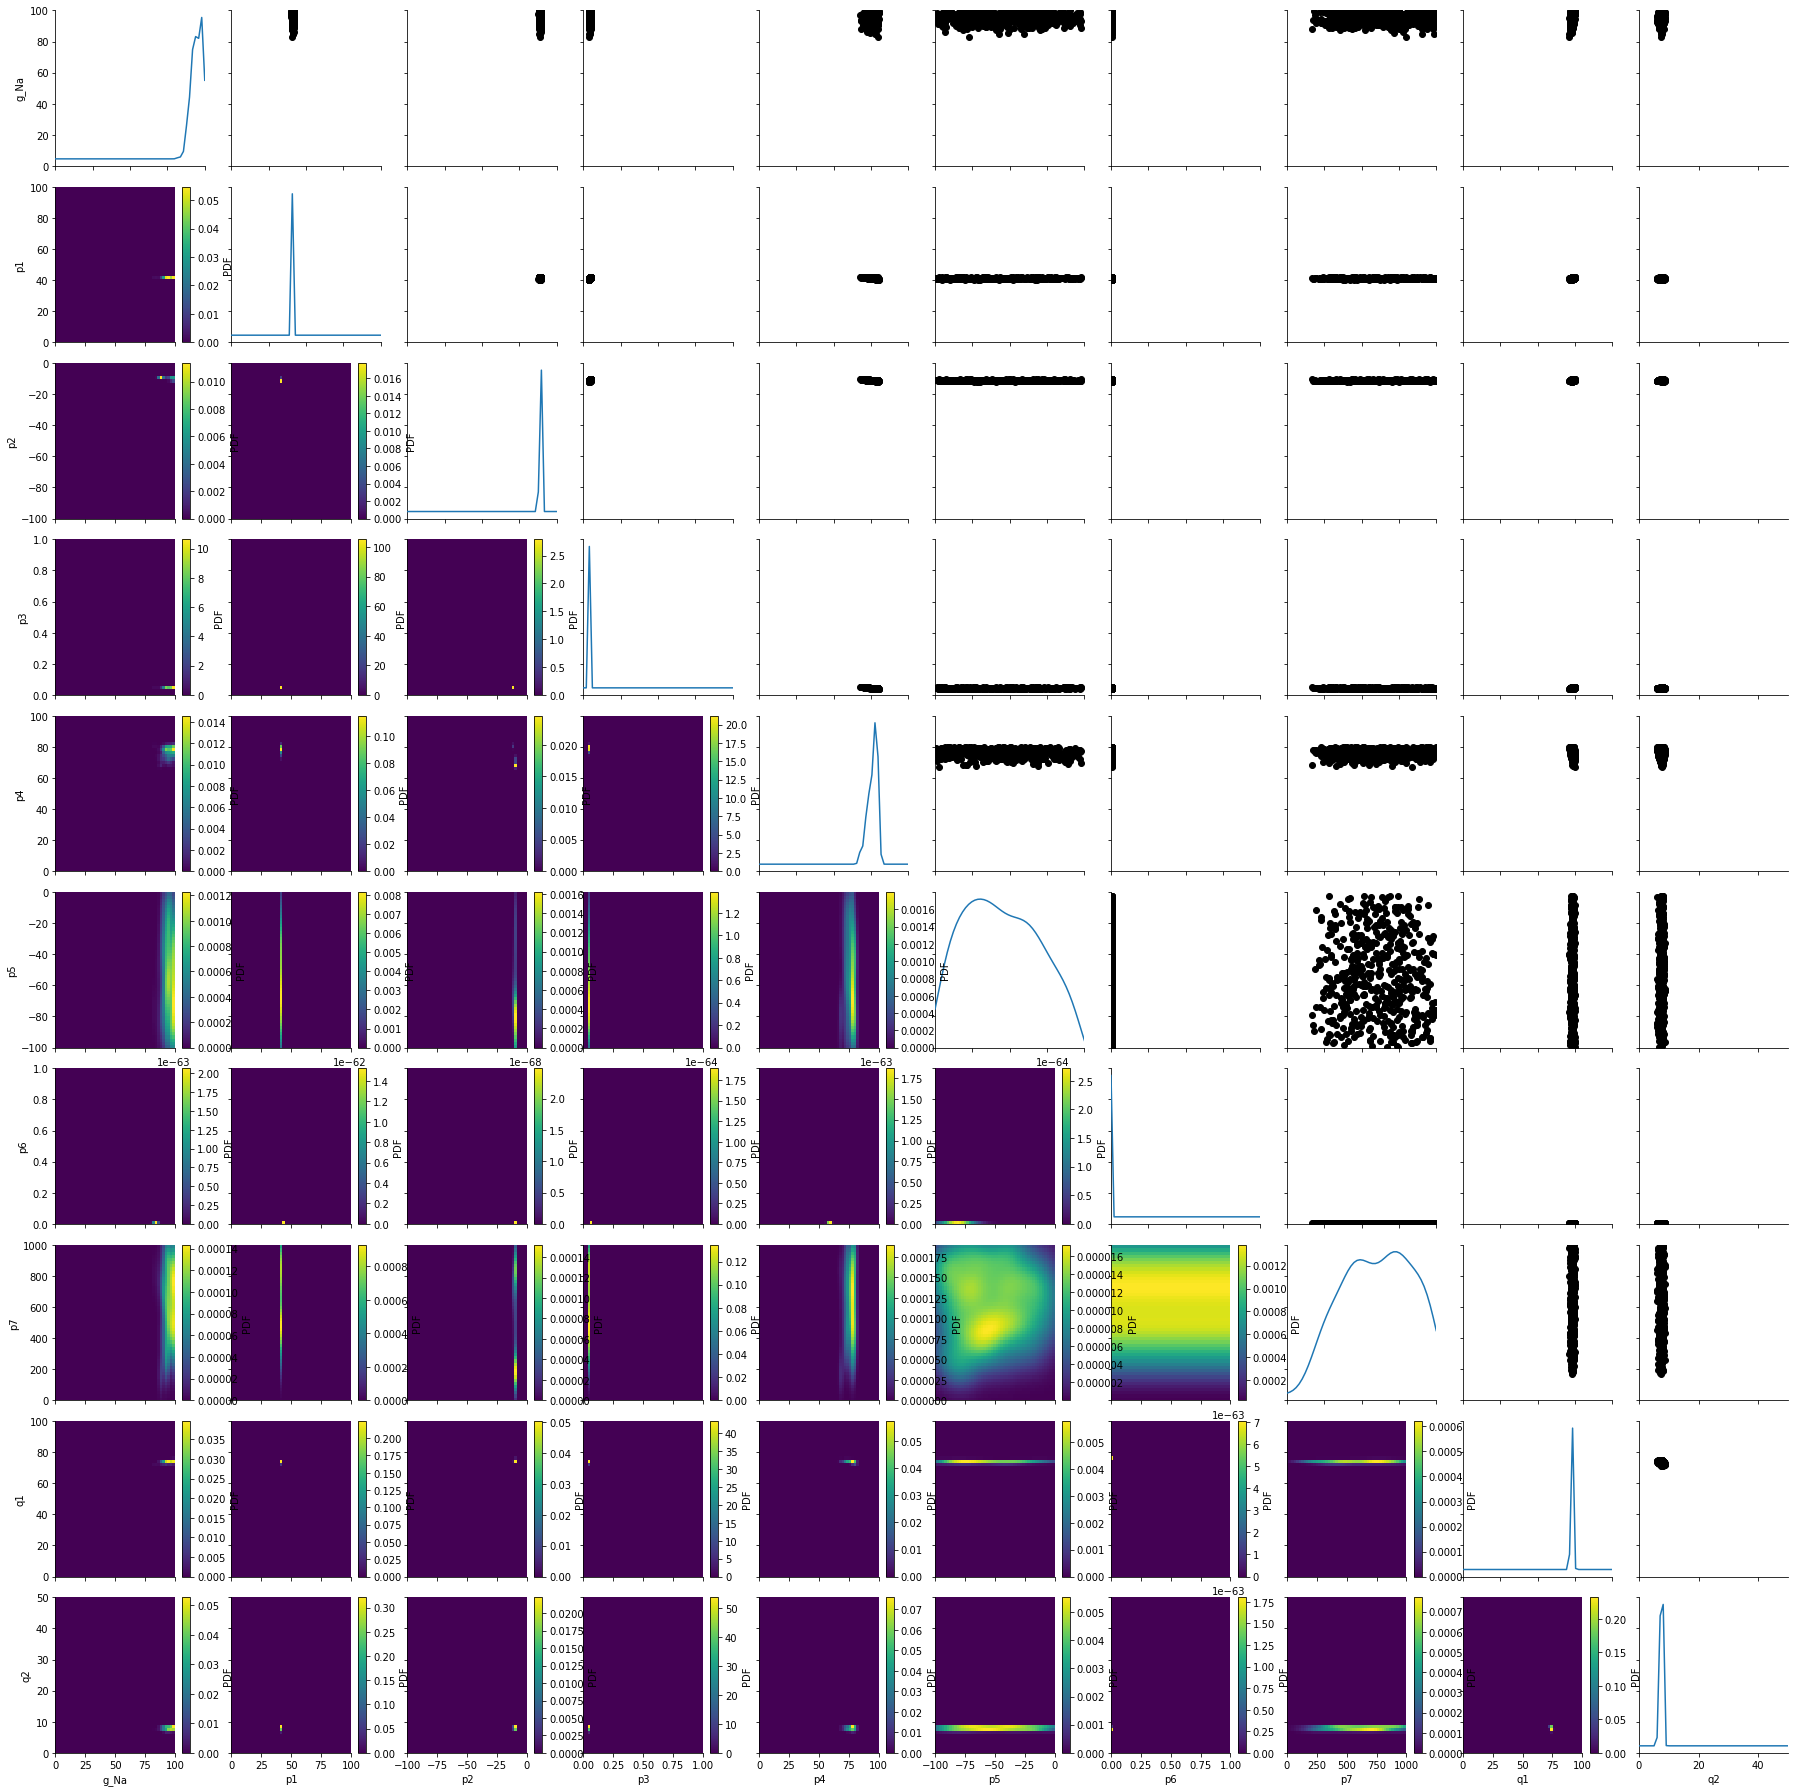

In [15]:
df, w = history.get_distribution(m=0)
plot_kde_matrix(df, w, limits=limits)

In [ ]:
history = abc.run(max_nr_populations=20, minimum_epsilon=0.01)

## Post processing of run

Note: from below assume the database file has been copied
      into the directory from /tmp/

In [7]:
history = History('sqlite:///pyabc-runs/ina_korhonen.db')

In [8]:
history.all_runs()

[<ABCSMC(id=1, start_time=2018-05-08 22:30:08.926659, end_time=2018-05-10 01:33:41.100451)>]

In [ ]:
from IPython.display import HTML
from visualization_custom import animate_kde_matrix
ani = animate_kde_matrix(history, n_frames=50, limits=limits, colorbar=False)
HTML(ani.to_jshtml())
#ani.save('converging.gif', dpi=80)

/tmp/chouston/miniconda3/envs/pyabc/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


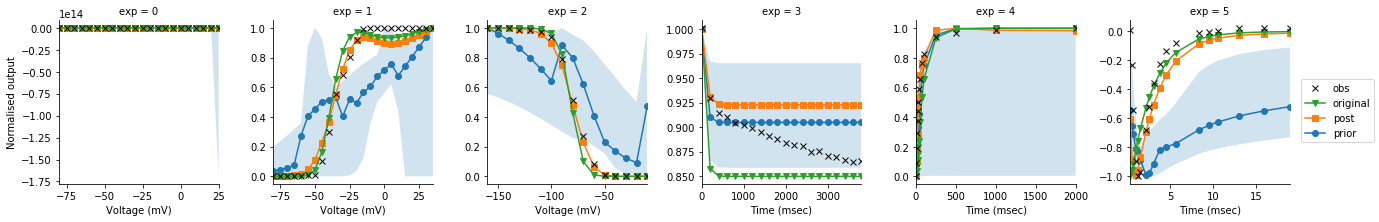

In [11]:
from visualization_custom import plot_sim_results
g = plot_sim_results(history, 'ina_nrvm', n_samples=5, obs=measurements)
xlabels = ["Voltage (mV)", "Voltage (mV)", "Voltage (mV)", "Time (msec)", "Time (msec)", "Time (msec)"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
g.axes.flatten()[0].set_ylabel("Normalised output")
plt.savefig('korhonen_results.pdf', format='pdf', dpi=1000) # save to disk

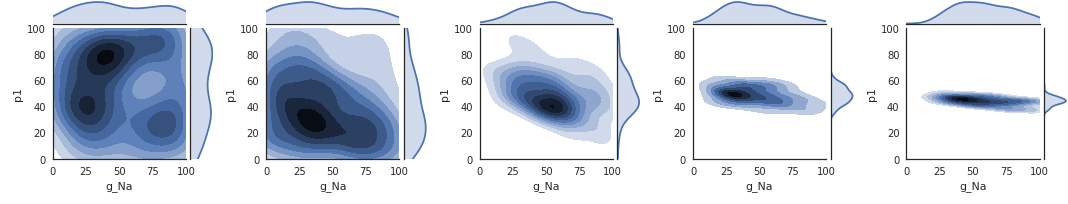

In [19]:
from visualization_custom import plot_kde_2d_custom
g = plot_kde_2d_custom(history, "g_Na", "p1", times=[0, 1, 5, 10, 20], limits=limits)
#plt.savefig('convergence.pdf', format='pdf', dpi=1000)

In [20]:
df, w = history.get_distribution(m=0)
df['wt'] = w
print("Mean")
for key in limits.keys():
    print(key, ":", sum(df[key] * df.wt))
print("Min")
for key in limits.keys():
    print(key, ":", min(df[key]))
print("Max")
for key in limits.keys():
    print(key, ":", max(df[key]))

Mean
g_Na : 94.73918295940223
p1 : 41.14682071640757
p2 : -11.141347757739029
p3 : 0.04358779909699389
p4 : 75.98330498045672
p5 : -54.432786703924705
p6 : 0.006149911340516833
p7 : 613.3748256511038
q1 : 73.31504045947982
q2 : 7.559231689152159
Min
g_Na : 82.67360697726224
p1 : 40.12511354531544
p2 : -12.194710327524712
p3 : 0.03698457031334849
p4 : 67.2411064147113
p5 : -99.58849095056627
p6 : 0.00410786934596343
p7 : 170.32109407276337
q1 : 71.32619589937764
q2 : 5.951588246717413
Max
g_Na : 99.98815984190682
p1 : 42.270888769378054
p2 : -10.173921668648543
p3 : 0.05392458516469772
p4 : 79.99962534861963
p5 : -2.2232329149652865
p6 : 0.0075267658638806375
p7 : 996.5467757392244
q1 : 74.98902777446312
q2 : 8.70691230451122


sample
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
2    AxesSubplot(0.125,0.125;0.775x0.755)
3    AxesSubplot(0.125,0.125;0.775x0.755)
4    AxesSubplot(0.125,0.125;0.775x0.755)
5    AxesSubplot(0.125,0.125;0.775x0.755)
6    AxesSubplot(0.125,0.125;0.775x0.755)
7    AxesSubplot(0.125,0.125;0.775x0.755)
8    AxesSubplot(0.125,0.125;0.775x0.755)
9    AxesSubplot(0.125,0.125;0.775x0.755)
dtype: object

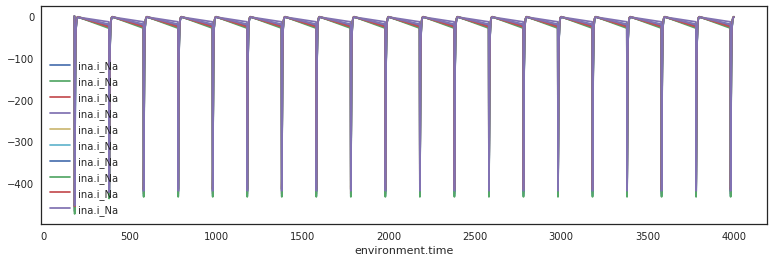

In [27]:
out = pd.DataFrame({})
n_samples = 10
df, w = history.get_distribution(m=0)
par_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')
for i, pars in enumerate(par_samples):
    output = simulate('ina_nrvm', experiment=3, logvars=['environment.time', 'ina.i_Na'], **pars)
    output['sample'] = i
    out = out.append(output, ignore_index=True)
fig, ax = plt.subplots(figsize=(13, 4))
out.groupby("sample").plot(x="environment.time", y="ina.i_Na", ax=ax)

-445.1308

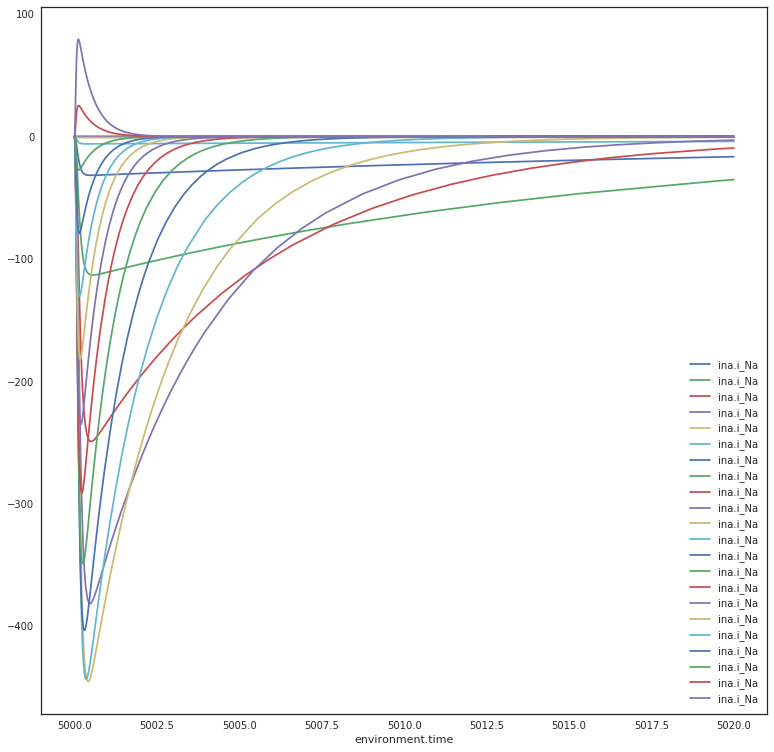

In [28]:
out = simulate("ina_nrvm", experiment=0, logvars=['environment.time', 'ina.i_Na'])
fig,ax = plt.subplots(figsize=(13,13))
out.groupby("run").plot(x="environment.time", y="ina.i_Na",ax=ax)
min(out['ina.i_Na'])

sample
0     AxesSubplot(0.547727,0.125;0.352273x0.755)
1     AxesSubplot(0.547727,0.125;0.352273x0.755)
2     AxesSubplot(0.547727,0.125;0.352273x0.755)
3     AxesSubplot(0.547727,0.125;0.352273x0.755)
4     AxesSubplot(0.547727,0.125;0.352273x0.755)
5     AxesSubplot(0.547727,0.125;0.352273x0.755)
6     AxesSubplot(0.547727,0.125;0.352273x0.755)
7     AxesSubplot(0.547727,0.125;0.352273x0.755)
8     AxesSubplot(0.547727,0.125;0.352273x0.755)
9     AxesSubplot(0.547727,0.125;0.352273x0.755)
10    AxesSubplot(0.547727,0.125;0.352273x0.755)
11    AxesSubplot(0.547727,0.125;0.352273x0.755)
12    AxesSubplot(0.547727,0.125;0.352273x0.755)
13    AxesSubplot(0.547727,0.125;0.352273x0.755)
14    AxesSubplot(0.547727,0.125;0.352273x0.755)
15    AxesSubplot(0.547727,0.125;0.352273x0.755)
16    AxesSubplot(0.547727,0.125;0.352273x0.755)
17    AxesSubplot(0.547727,0.125;0.352273x0.755)
18    AxesSubplot(0.547727,0.125;0.352273x0.755)
19    AxesSubplot(0.547727,0.125;0.352273x0.755)
20    AxesSub

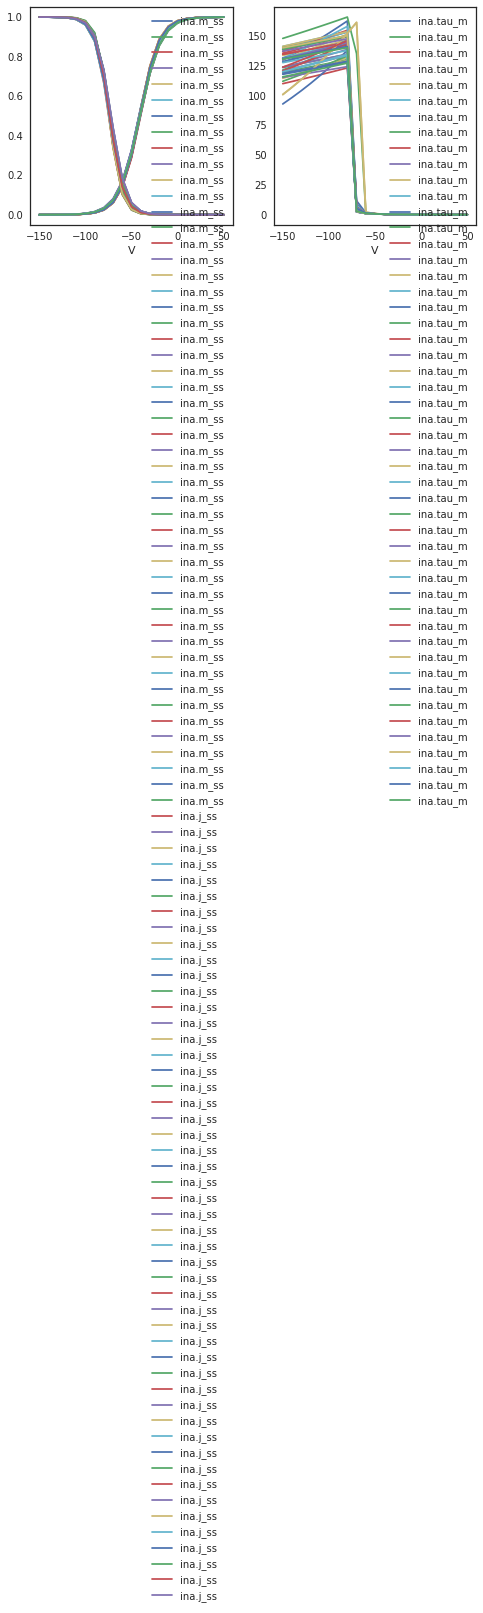

In [32]:
out = pd.DataFrame({})
n_samples=50
df, w = history.get_distribution(m=0)
variables = ['ina.m_ss', 'ina.tau_m', 'ina.j_ss', 'ina.tau_j', 'ina.tau_h']
par_samples = df.sample(n=n_samples, weights=w, replace=True).to_dict(orient='records')
for i, pars in enumerate(par_samples):
    output = voltage_dependence('ina_nrvm', variables, **pars)
    output['sample'] = i
    out = out.append(output, ignore_index=True)
fig, ax = plt.subplots(figsize=(8, 4), ncols=2)
out.groupby("sample").plot(x="V", y="ina.m_ss", ax=ax[0])
out.groupby("sample").plot(x="V", y="ina.j_ss", ax=ax[0])
out.groupby("sample").plot(x="V", y="ina.tau_m", ax=ax[1])

## Code to continue run from db file

In [ ]:
abc_continued = ABCSMC(models=MyokitSimulation(),
                       parameter_priors=prior,
                       distance_function=distance,
                       population_size=AdaptivePopulationSize(
                           5000, 0.5, 
                           min_population_size=500,
                           max_population_size=10000), 
                       eps=MedianEpsilon(100, median_multiplier=1))
abc_continued.load(db_path, 2)
abc_continued.run(max_nr_populations=20, minimum_epsilon=0.01)

# Reproducing graphs after original model correction 22/06/18

In [7]:
history = History('sqlite:///pyabc-runs/ina_korhonen.db')

In [8]:
history.all_runs()

[<ABCSMC(id=1, start_time=2018-05-08 22:30:08.926659, end_time=2018-05-10 01:33:41.100451)>]

In [13]:
df, w = history.get_distribution(m=0)
df['wt'] = w
print("Mean")
for key in limits.keys():
    print(key, ":", sum(df[key] * df.wt))
print("Min")
for key in limits.keys():
    print(key, ":", min(df[key]))
print("Max")
for key in limits.keys():
    print(key, ":", max(df[key]))

Mean
p1 : 43.38490926584436
p2 : -11.568297173334178
p3 : 0.07169915152821386
p4 : 79.73278778491131
p5 : -36.20632156988179
p6 : 0.0034498366860866644
p7 : 682.3775368069931
q1 : 72.4523151281337
q2 : 9.542724014676946
Min
p1 : 43.18969239286858
p2 : -11.640834593505838
p3 : 0.07071347163520575
p4 : 79.31435972852462
p5 : -49.95693954637773
p6 : 0.003023495345711099
p7 : 325.07747092994776
q1 : 71.89464789157188
q2 : 8.821845730298763
Max
p1 : 43.55103014416312
p2 : -11.504848982654917
p3 : 0.07256571922104206
p4 : 79.91893767397417
p5 : -12.24486472752442
p6 : 0.0037288981921217218
p7 : 997.7497637120715
q1 : 73.09928459560523
q2 : 10.002241686933605


/tmp/chouston/miniconda3/envs/pyabc/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


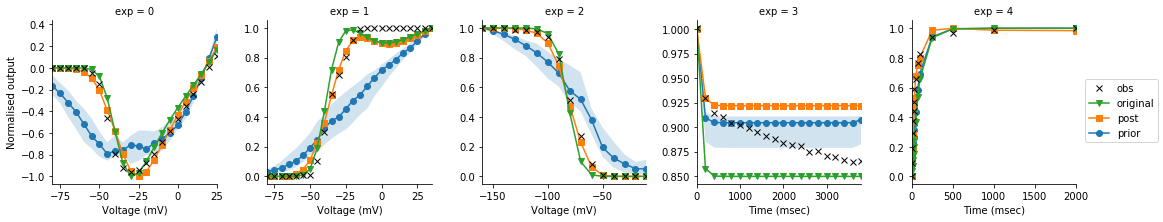

In [15]:
from visualization_custom import plot_sim_results
g = plot_sim_results(history, 'ina_nrvm', n_samples=100, obs=measurements)
xlabels = ["Voltage (mV)", "Voltage (mV)", "Voltage (mV)", "Time (msec)", "Time (msec)", "Time (msec)"]
for ax, xl in zip(g.axes.flatten(), xlabels):
    ax.set_xlabel(xl)
g.axes.flatten()[0].set_ylabel("Normalised output")
plt.savefig('korhonen_results.pdf', format='pdf', dpi=1000) # save to disk